# Hedging P&L Analysis in Gamma Trading

In this notebook, we investigate impact of different hedging strategies on P&L in gamma trading.

In [5]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline

def option_price(spot, strike, vol, tau, r, phi):
    var = vol * np.sqrt(tau)
    d1 = (np.log(spot / strike) + r * tau + 0.5 * var ** 2) / var
    d2 = d1 - var

    v1 = scipy.stats.norm.cdf(phi * d1)
    v2 = scipy.stats.norm.cdf(phi * d2)

    price = phi * (spot * v1 - strike * np.exp(-r * tau) * v2)

    return price


def option_delta(spot, strike, vol, tau, r, phi):
    var = vol * np.sqrt(tau)
    d1 = (np.log(spot / strike) + r * tau + 0.5 * var ** 2) / var
    v1 = scipy.stats.norm.cdf(phi * d1)

    delta = phi * v1

    return delta


def hedge_pnl_sim_single(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep):
    '''
        This function simulates one sample path for underlying prices and compute delta hedged pnl of an option.
        
        implied_vol: implied volatility which market is using to price an option
        realized_vol: actual volatility for the underlying prices
        hedge_vol: volatility that is used for computing the delta hedge ratio
        phi: 1.0 for call option and -1.0 for put option
    '''
    
    dt = tau / nstep
    taus = np.array([tau - dt * i for i in range(nstep)])

    # simulate underlying prices using realized vol
    rvs = scipy.stats.norm.rvs(size=nstep - 1)
    ds = np.exp((r - 0.5 * realized_vol**2) * dt + realized_vol * np.sqrt(dt) * rvs)
    prices = np.insert(ds, 0, spot)
    prices = prices.cumprod()

    # compute option prices using implied vol and deltas for hedging using hedge vol.
    option_prices = option_price(prices, strike, implied_vol, taus, r, phi)
    hedge_deltas = option_delta(prices, strike, hedge_vol, taus, r, phi)

    # calculate value of hedged option excluding the initial premium paid for the option (see slides for the formula)
    hedged_value = [0.0] * nstep
    hedged_value[0] = hedge_deltas[0] * prices[0]
    for i in range(1, nstep):
        hedged_value[i] = hedged_value[i - 1] * np.exp(r * dt) + (hedge_deltas[i] - hedge_deltas[i-1]) * prices[i]
    for i in range(nstep):
        hedged_value[i] += option_prices[i] - hedge_deltas[i] * prices[i]

    # calculate pnl: hedged value - initial premium on option plus interest
    hedged_pnl = [0.0] * nstep
    for i in range(nstep):
        hedged_pnl[i] = hedged_value[i] - option_prices[0] * np.exp(r * i * dt)

    return hedged_pnl


def hedge_pnl_sim(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep, nsim):
    '''
        Simulate hedged P&L for options
    '''
    pnls = []
    for i in range(nsim):
        hedged_pnl = hedge_pnl_sim_single(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep)
        pnls.append(hedged_pnl)

    return pnls


def plot_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec):
    spot = option_spec['spot']
    strike =  option_spec['strike']
    r =  option_spec['ir']
    tau =  option_spec['tau']
    phi =  option_spec['phi']
    nstep = sim_spec['nstep']

    pnls = hedge_pnl_sim(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep, sim_spec['nsim'])

    # plot hedged pnl
    plt.xlim(0, 1.1)
    plt.xlabel(plot_spec['xlabel'])
    plt.ylabel(plot_spec['ylabel'])
    plt.title(plot_spec['title'])
        
    max_pnl = np.max([np.max(pnl) for pnl in pnls])
    annotations = 'spot price = {}'.format(spot)
    annotations += '\n'
    annotations += 'strike = {}'.format(strike)
    annotations += '\n'
    annotations += 'impl vol = {}'.format(implied_vol)
    annotations += '\n'
    annotations += 'act vol = {}'.format(realized_vol)
    plt.annotate(annotations, xy=(0.5, max_pnl), va='top', ha='center')

    ts = np.linspace(0, tau, nstep)
    for pnl in pnls:
        plt.plot(ts, pnl)

    plt.show()

    
def plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec):
    # hedge with implied vol
    spot = option_spec['spot']
    strike =  option_spec['strike']
    r = option_spec['ir']
    tau = option_spec['tau']
    phi = option_spec['phi']
    
    nstep = sim_spec['nstep']
    nsim = sim_spec['nsim']

    pnls = hedge_pnl_sim(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep, nsim)
    pnls = np.array([pnl[-1] for pnl in pnls])

    n, bins, patches = plt.hist(pnls, 20, density=True, alpha=0.75)

    plt.xlabel(plot_spec['xlabel'])
    plt.ylabel(plot_spec['ylabel'])
    plt.title(plot_spec['title'])
    
    plt.ylim(0.0, np.max(n) * 1.3)
    plt.text(bins[0] * 0.8 + bins[1] * 0.2, np.max(n) * 1.2, 
             'Implied vol = {:.2f}, act vol = {:.2f}, # of hedge = {}'.format(implied_vol, realized_vol, nstep))
    plt.text(bins[0] * 0.8 + bins[1] * 0.2, np.max(n) * 1.1, 'mean ={:.2f}, std={:.2f}'.format(np.mean(pnls), np.std(pnls)))
    
    plt.show()

    
def plot_hedge_pnl_all():
    # plot hedge pnl with different hedging vol
    option_spec = {
        'spot' : 100.0,
        'strike' : 100.0,
        'ir' : 0.05,
        'tau' : 1.0,
        'phi' : 1.0, # call option
    }
    
    # ------------------- plot impact of hedge vol on P&L ------------------- 
    plot_spec = {
        'xlabel' : 'Time',
        'ylabel' : 'Hedged P&L',
        'title' : 'Hedge with Implied Volatility'
    }
    
    implied_vol = 0.2
    realized_vol = 0.3
    
    # use implied vol for hedging
    sim_spec = {
        'nstep' : 10000,
        'nsim' : 20,
    }
    hedge_vol = implied_vol 
    plot_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)
    
    # use realized vol for hedging
    sim_spec = {
        'nstep' : 10000,
        'nsim' : 10,
    }
    hedge_vol = realized_vol 
    plot_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)


def plot_discrete_hedge_pnl_all():  
    
    # ------------------- plot impact of hedge frequency on P&L ------------------- 
    option_spec = {
        'spot' : 100.0,
        'strike' : 100.0,
        'ir' : 0.0,
        'tau' : 1.0 / 12,
        'phi' : 1.0, # call option
    }
    plot_spec = {
        'xlabel' : 'Final P&L',
        'ylabel' : 'Probability Density',
        'title' : 'Discrete Hedge P&L'
    }
    
    # plot histogram for hedged P&L when implied vol is equal to realized vol
    implied_vol = 0.2
    realized_vol = 0.2
    hedge_vol = implied_vol
    
    sim_spec = {
        'nstep' : 21,
        'nsim' : 10000,
    }
    plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)

    sim_spec = {
        'nstep' : 84,
        'nsim' : 10000,
    }
    plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)

    # plot histogram for hedged P&L when implied vol is slightly smaller than realized vol
    implied_vol = 0.2
    realized_vol = 0.25
    hedge_vol = implied_vol
    
    sim_spec = {
        'nstep' : 21,
        'nsim' : 10000,
    }
    plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)

    sim_spec = {
        'nstep' : 84,
        'nsim' : 10000,
    }
    plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)
    
    
    # plot histogram for hedged P&L when implied vol is much smaller than realized vol
    implied_vol = 0.2
    realized_vol = 0.4
    hedge_vol = implied_vol
    
    sim_spec = {
        'nstep' : 21,
        'nsim' : 10000,
    }
    plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)

    sim_spec = {
        'nstep' : 84,
        'nsim' : 10000,
    }
    plot_discrete_hedge_pnl(option_spec, implied_vol, realized_vol, hedge_vol, plot_spec, sim_spec)
    

def plot_transaction_cost():
    spot = 100.0
    strike = 100
    vol = 0.3
    tau = 1.0 / 12
    r = 0.02
    phi = 1.0

    frequency = np.linspace(1, 100, 100)
    dts = tau / frequency

    original_price = option_price(spot, strike, vol, tau, r, phi)

    k = 0.1 / 100
    vols = np.sqrt(vol ** 2 - 2 * k * vol * np.sqrt(2/(np.pi * dts)))
    prices = option_price(spot, strike, vols, tau, r, phi)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(np.insert(frequency, 0, 0), np.insert(prices, 0, original_price), color='blue')
    l2 = ax2.plot(np.insert(frequency, 0, 0), original_price - np.insert(prices, 0, original_price),  color='red')

    ax1.set_xlabel('# of Hedge')
    ax1.set_ylabel('Option Value')
    ax2.set_ylabel('Transaction Cost')
    plt.title('Impact of Hedge Frequency on Option Value')
    
    plt.legend([l1[0], l2[0]], ['Option Value', 'Transaction Cost'], loc='upper center')
    plt.show()
    

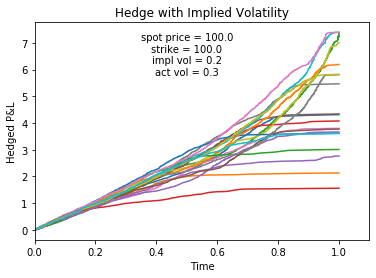

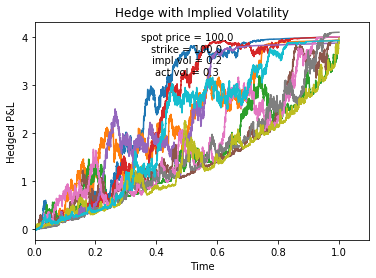

In [6]:
# plot impact of hedge vol on P&L
plot_hedge_pnl_all()

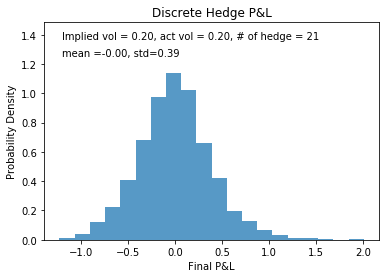

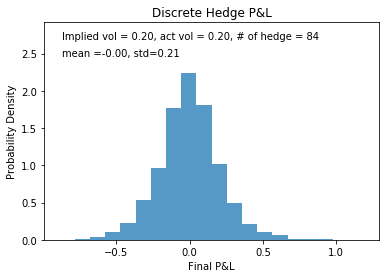

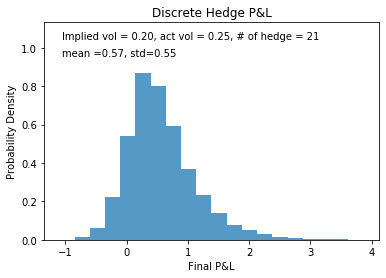

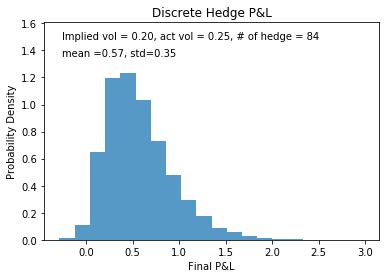

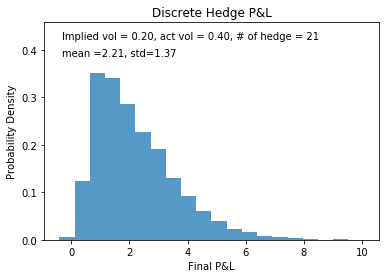

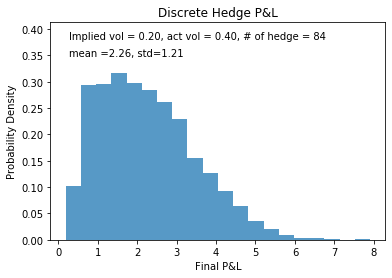

In [7]:
# plot the impact of hedge frequency on P&L
plot_discrete_hedge_pnl_all()

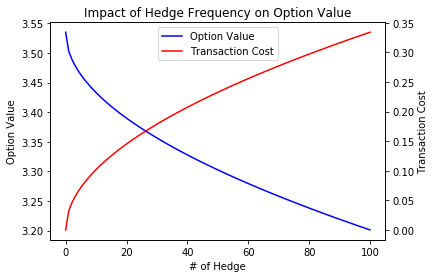

In [8]:
plot_transaction_cost()